# Anomaly detection in technical systems: anomaly in the water circulation loop

## Testbed description

The testbed of the industrial Internet of things is intended for:

- Demonstration of the possibilities and benefits associated with the implementation of industrial Internet of things technologies;
- Approbation, verification and validation of new technologies related to the industrial Internet of Things in laboratory conditions in order to determine a set of scientific theories, algorithms and practical tools for the application of these technologies in urgent industrial problems;
- Conducting educational and research work on the subject of the industrial Internet of things.

The simple and intuitive user interface of the program allows you to operate the systems in accordance with the instructions presented in the user manual separately.

The testbed is a closed-loop water pump, a power supply system, control systems, data collection and monitoring system, built using industrial Internet of things technologies.
The stand consists of the following systems:

1. Water circulation system.
2. Control system of the water circulation system (hereinafter referred to as the Control System).
3. System for monitoring the state of the water circulation system (hereinafter - Monitoring System).
4. TSN technology demonstration system.
5. System for storing, processing and visualizing data.

The water circulation system is designed to simulate a water supply system in a laboratory environment and circulates water through water pipes using a water pump.
The water circulation system simulates the following faults:

- Introduction of imbalance on the connecting shaft (misalignment) of the motor and the water pump;
- Changing the flow rate of the valve at the pump inlet (REDUCTION OF FLOW AREA);
- Changing the flow rate of the valve at the pump outlet (REDUCTION OF FLOW AREA).

The system consists of the following components:
- Water pump
- Electric motor
- Inverter
- Electrovalve (1)
- Electrovalve (2)
- Mechanical lever for misalignment
- Vibration sensors
- Water tank with pipes
- Pressure sensor
- Flow meter
- Thermocouple

Front panel and composition of the water circulation, control and monitoring systems: 1,2 - solenoid valve (amount - 1); 3 - a tank with water (1); 4 - a water pump (1); 5 - emergency stop button (1); 6 - electric motor (1); 7 - inverter (1); 8 - compactRIO (1); 9 - a mechanical lever for shaft misalignment (1). Not shown parts - vibration sensor (2); pressure meter (1); flow meter (1); thermocouple (2).

## Working with the data

The dataset contains 4 anomalies (incidents):

- MISALIGNMENT OF THE PUMP AND ENGINE SHAFT (abruptly)  
Abrupt appearance of a defect: 18:39:22  
Abrupt defect shutdown: 18:42:32

- MISALIGNMENT OF PUMP AND MOTOR SHAFT (slow)  
Slow appearance of the defect: 18:44:36-18:45:49  
Abrupt defect shutdown: 18:46:51

- REDUCTION OF FLOW AREA SECTION-1 (top)  
Slow appearance of the defect: 19:06:57-19:07:37  
Slow defect shutdown: 19:10:45-19:11:31

- REDUCTION OF FLOW AREA SECTION-2 (bottom)  
Slow appearance of the defect: 19:14:40-19:16:24  
Slow defect shutdown: 19:19:15-19:21:16

## Problem statement

- **DS problem in terms of business:** We need to detect anomalies as soon as they appear.

Metric:
Average Detection Delay (ADD)

$\text{ADD} = \frac{1}{|Y|}\sum_{y \in Y} ( \tau_y - \theta_y )$,

where $|Y|$ - total amount of changepoints,  
$\tau_y$ - moment of detection,  
$\theta_y$ - moment of changepoint (anomaly appearing).

- **DS problem in terms of math:** We need to propose (construct) the model, that most accurately describes the normal operation of the testbed.

Metric:
Mean Absolute Error (MAE)

$\text{MAE} = \frac{1}{N} \sum^{N}_{i=1}|x_i - \hat{x}_i|$,

where $N$ - Total amount of data instances,  
$x_i$ - true value at a time moment $i$,  
$\hat{x}_i$ - predicted value at a time moment $i$.

### Libraries importing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline

### Data loading

In [ ]:
# Reading the data
raw_data = pd.read_csv('/content/SkAB teaser.csv',
                   sep=';',
                   index_col='datetime',
                   parse_dates=True).drop('index',axis=1)

In [ ]:
# Showing the first 10 rows of the table with the data
raw_data.head(10)

,id,value
datetime,,
2019-07-08 17:02:14,Current,0.000749
2019-07-08 17:02:14,Temperature,28.209900
2019-07-08 17:02:14,Voltage,252.743000
2019-07-08 17:02:14,Accelerometer1RMS,0.042830
2019-07-08 17:02:14,Accelerometer2RMS,0.080612
2019-07-08 17:02:14,Volume Flow RateRMS,37.024200
2019-07-08 17:02:14,Pressure,-0.273216
2019-07-08 17:02:14,Thermocouple,23.445700
2019-07-08 17:02:32,Current,0.000849


Let's pivot the table, because we need each signal to be in the separate column.

In [ ]:
# Pivoting the table
raw_data = raw_data.pivot_table(values='value', index=raw_data.index, columns='id')

In [ ]:
# Showing first 5 rows of the table
raw_data.head()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
datetime,,,,,,,,
2019-07-08 17:02:14,0.042830,0.080612,0.000749,-0.273216,28.2099,23.4457,252.743,37.0242
2019-07-08 17:02:32,0.043330,0.084116,0.000849,0.054711,28.3486,23.4492,240.488,37.0000
2019-07-08 17:02:45,0.044111,0.082577,0.000764,0.054711,28.6534,23.4417,235.642,37.9764
2019-07-08 17:02:46,0.044244,0.079906,0.000914,-0.273216,28.8157,23.4417,229.536,37.0242
2019-07-08 17:02:47,0.042298,0.081938,0.000768,0.054711,28.3558,23.4362,239.926,37.9764


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6405 entries, 2019-07-08 17:02:14 to 2019-07-08 19:21:51
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Accelerometer1RMS    6405 non-null   float64
 1   Accelerometer2RMS    6405 non-null   float64
 2   Current              6405 non-null   float64
 3   Pressure             6405 non-null   float64
 4   Temperature          6405 non-null   float64
 5   Thermocouple         6405 non-null   float64
 6   Voltage              6405 non-null   float64
 7   Volume Flow RateRMS  6405 non-null   float64
dtypes: float64(8)
memory usage: 450.4 KB


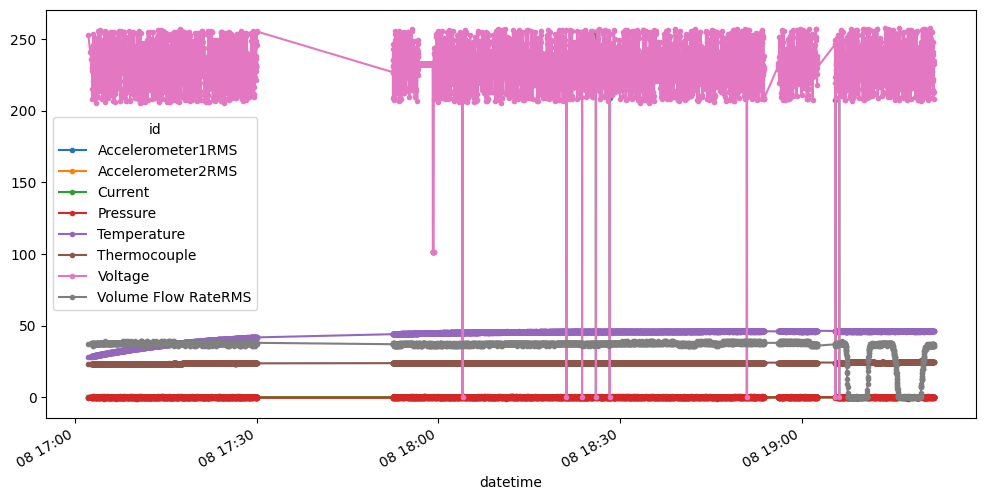

In [ ]:
# Plotting
raw_data.plot(figsize=(12,6), marker='o', markersize=3);

Let's cut off the beginning interval of the data to exclude the transition period (warming up).

In [ ]:
# Cutting off
raw_data = raw_data['2019-07-08 17:52:29':]

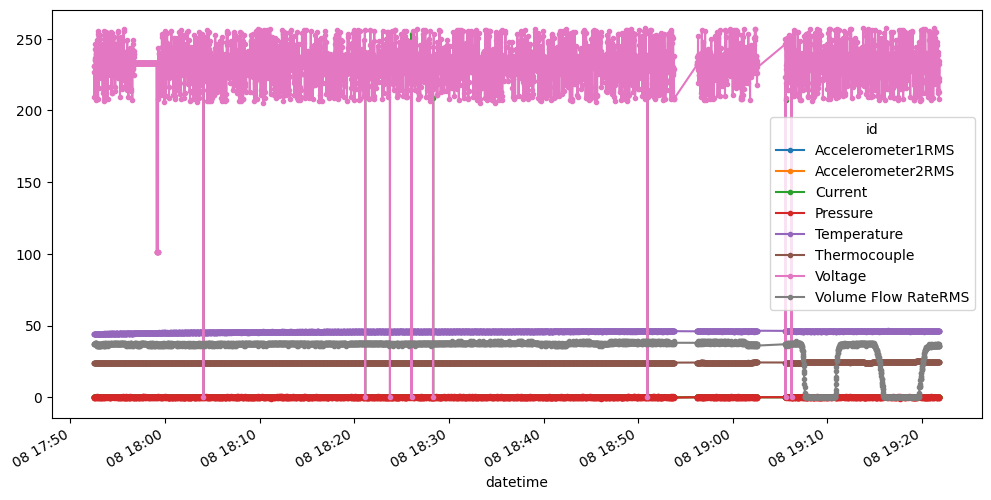

In [ ]:
# Plotting
raw_data.plot(figsize=(12,6), marker='o', markersize=3);

In [ ]:
# Saving processed data
# raw_data.to_csv('raw_data.csv')

In [ ]:
print(f'The shape of the table (dataframe): {raw_data.shape}')

The shape of the table (dataframe): (4838, 8)


### Features

In [ ]:
raw_data.describe()

id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
count,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000,4838.000000
mean,0.039935,0.067975,0.327774,0.036139,45.763933,24.080946,231.892940,33.889386
std,0.014497,0.017103,8.610388,0.256636,0.511680,0.207689,15.404728,10.661003
min,0.032501,0.052414,0.000215,-1.257000,43.897900,23.725900,0.000643,0.000000
25%,0.035849,0.061865,0.000706,0.054711,45.571925,23.948725,227.946250,37.000000
50%,0.036491,0.064238,0.000788,0.054711,45.914550,24.047900,232.797000,37.030400
75%,0.037184,0.066483,0.000860,0.054711,46.105350,24.161475,237.741250,37.992900
max,0.106967,0.148090,253.297000,1.038490,46.591500,25.032200,257.429000,38.969900


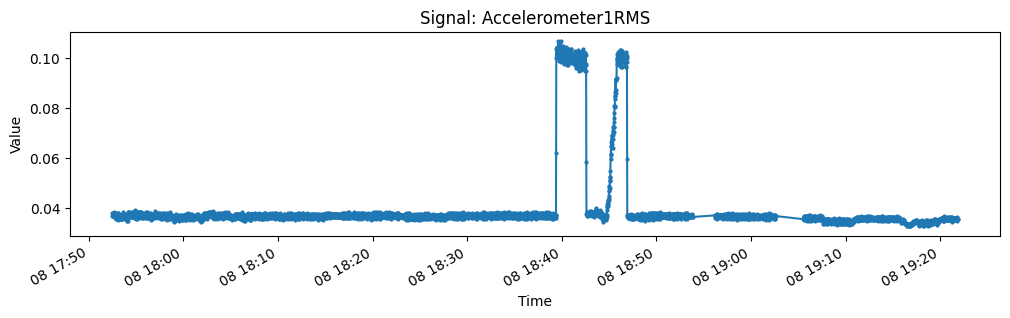

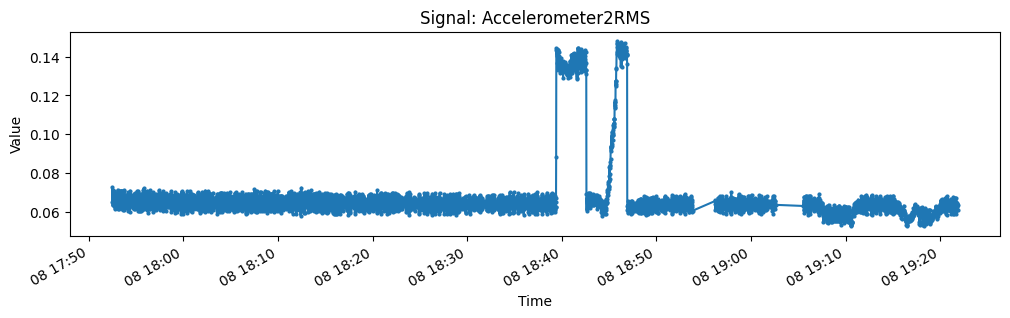

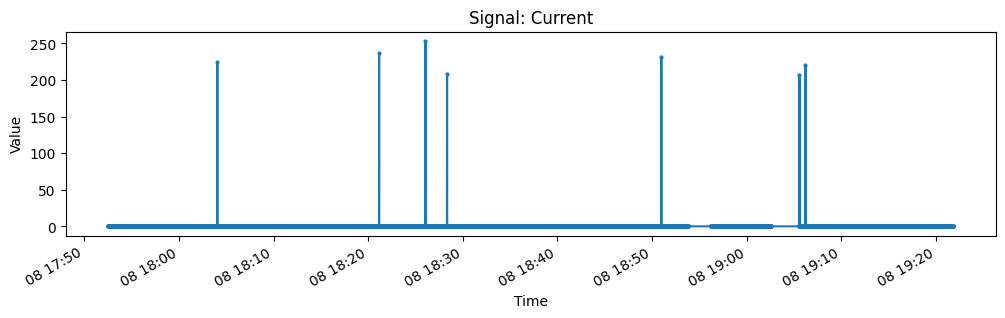

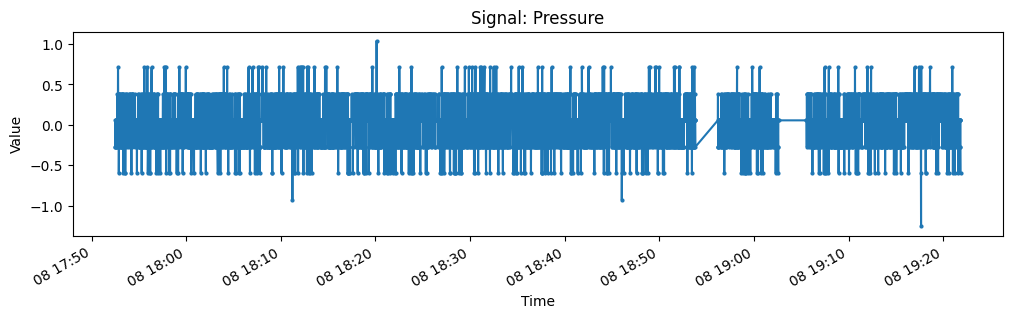

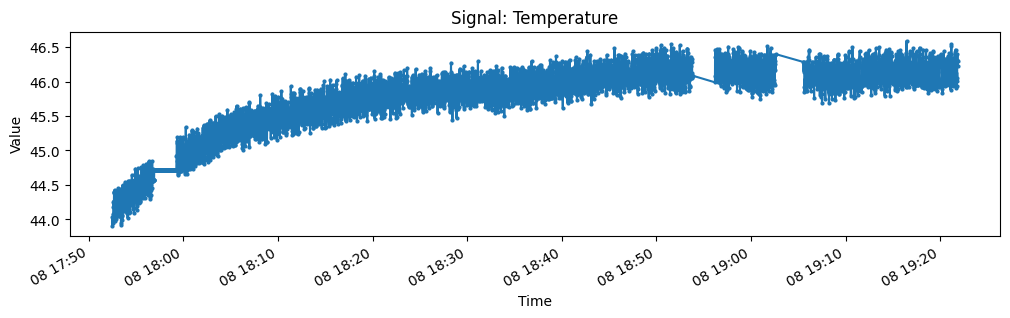

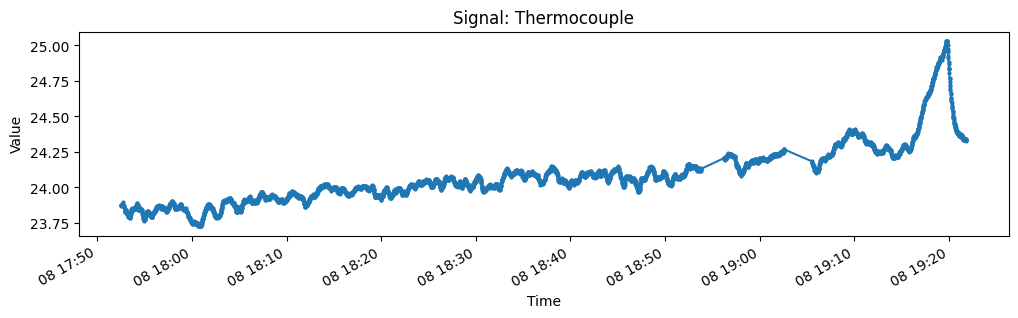

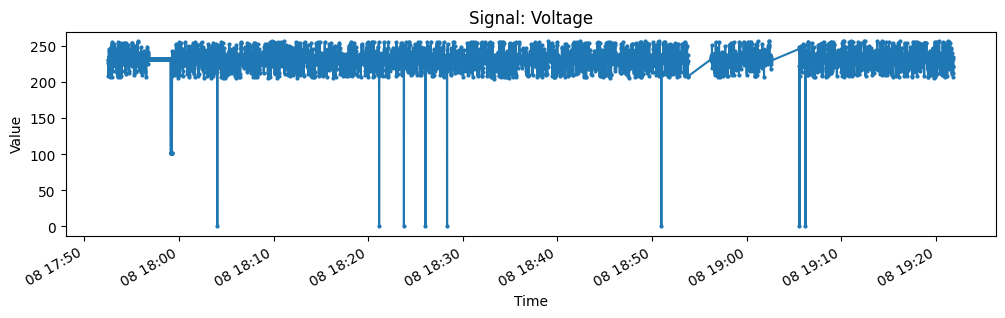

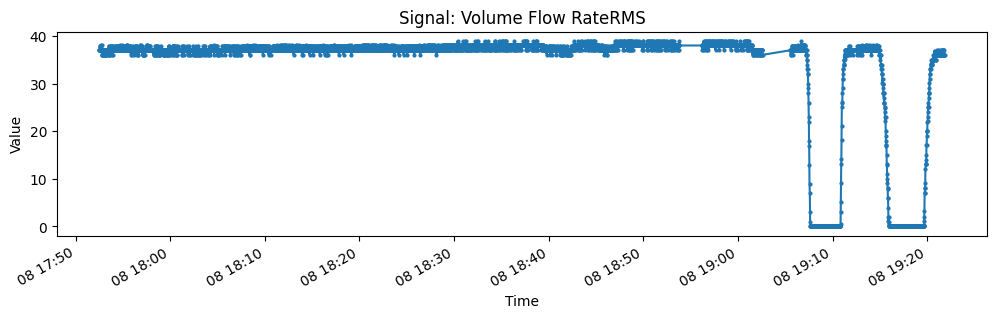

In [ ]:
# Plotting separate pictures for signals
for name in raw_data.columns:
    raw_data[name].plot(figsize=(12,3), marker='o', markersize=2)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Signal: {name}')
    plt.show()

### Additional data processing

In [ ]:
# todo
def preprocessing(raw_data):
    data = raw_data.copy()

    # your code

    return data

data = preprocessing(raw_data=raw_data)

### Splitting the data into training, validation and test sets

- training sample — sample for model's parameters optimization.
- validation sample — sample for selecting the best model from the set of models built on the training sample.
- test sample — sample for assesing the quality of the problem solution.

Descriptions and options for the definitions of training, validation and test samples are presented in the [article](https://medium.com/@tekaround/train-validation-test-set-in-machine-learning-how-to-understand-6cdd98d4a764).

[Article](https://hunch.net/?p=22) about overfitting in ML.

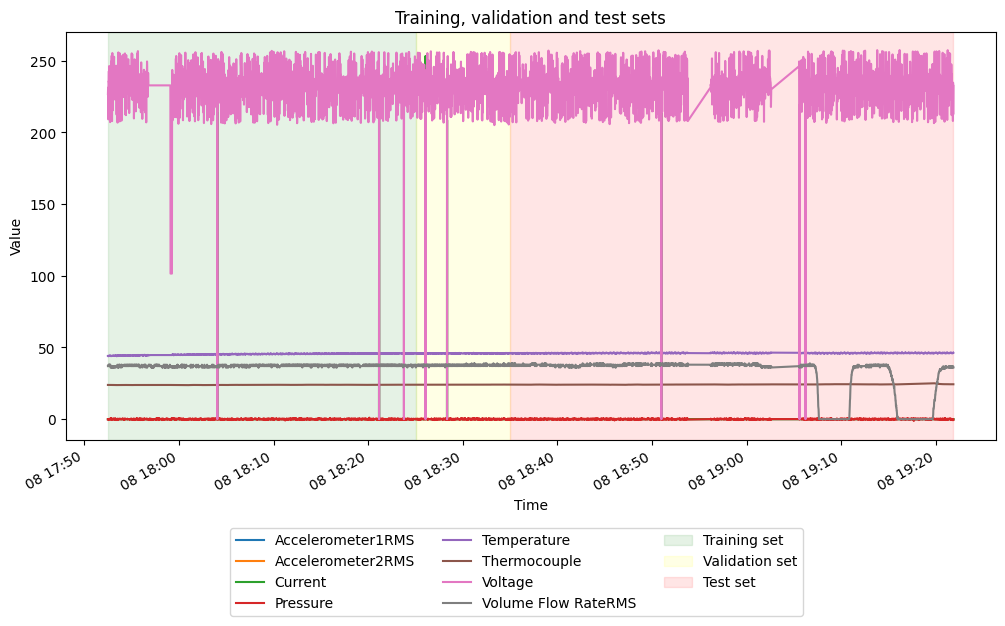

In [ ]:
# Showing the training, validation and test sets
data.plot(figsize=(12,6))
plt.axvspan(data.index[0],
            '2019-07-08 18:25',
            color='green',
            alpha=0.1,
            label='Training set')
plt.axvspan('2019-07-08 18:25',
            '2019-07-08 18:35',
            color='yellow',
            alpha=0.1,
            label='Validation set')
plt.axvspan('2019-07-08 18:35',
            data.index[-1],
            color='red',
            alpha=0.1,
            label='Test set')
plt.legend(bbox_to_anchor =(0.8, -0.2), ncol = 3)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Training, validation and test sets');

### Data scaling (normalizing)

Most of all ML algorithms need data to be scaled before fitting.

In [ ]:
# Scaler initialization
StSc = StandardScaler()
# Fitting Scaler on the training and validation sets
StSc.fit(data[:'2019-07-08 18:25'])

# Applying scaler
# training set
train_sc = StSc.transform(data[:'2019-07-08 18:25'])
# validation set
val_sc = StSc.transform(data['2019-07-08 18:25':'2019-07-08 18:35'])
# all data
data_sc = StSc.transform(data)

## Fitting the model

- Link to the Keras with TensorFlow backend course: https://youtu.be/qFJeN9V1ZsI

### Libraries importing

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product

### Function for results reproducibility

In [ ]:
def Random(seed_value):
    # 1. Set `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    # 2. Set `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)

    # 3. Set `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)

    # 4. Set `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    tf.random.set_seed(seed_value)

### Autoencoder description

![ae](https://miro.medium.com/max/700/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)

## Useful links

- Autoencoder Explained:
https://www.youtube.com/watch?v=H1AllrJ-_30

- Outlier Detection with Autoencoder Ensembles:
https://saketsathe.net/downloads/autoencode.pdf

- About batch normalization layer:
https://arxiv.org/pdf/1502.03167v2.pdf

In [ ]:
# Function for specific architecture fitting
def arch(param, data):
    """Specific architecture fitting

    Parameters
    ----------
    param : list

    data : np.array
    """
    Random(0)
    input_dots = Input((8,))

    x = Dense(param[0])(input_dots)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)

    x = Dense(param[1])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    bottleneck = Dense(param[2], activation='linear')(x)

    x = Dense(param[1])(bottleneck)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Dense(param[0])(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    out = Dense(8, activation='linear')(x)

    model = Model(input_dots, out)
    model.compile(optimizer=Adam(param[3]), loss='mae', metrics=["mse"])

    model.fit(data, data,
                validation_split=0.2,
                epochs=10,
                batch_size=param[4],
                verbose=0,
                shuffle=True,
               )
    return model

### Let's fit the random model (architecture)

In [ ]:
model = arch(param=(6, 5, 4, 0.0001, 30), data=train_sc)

20/20 [==============================] - 0s 2ms/step


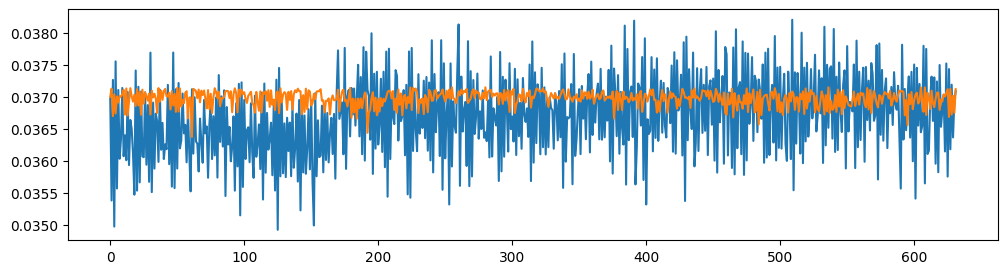

20/20 [==============================] - 0s 2ms/step


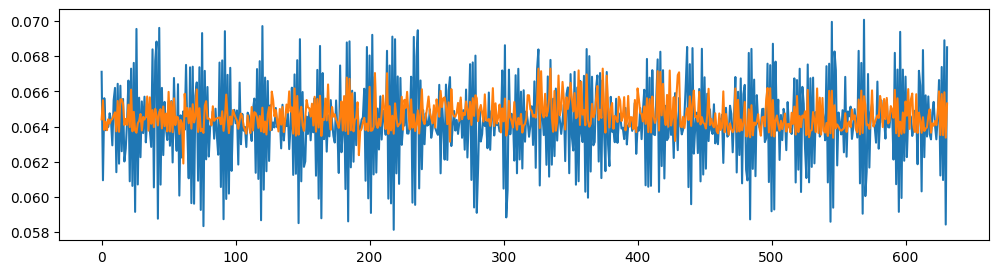

20/20 [==============================] - 0s 2ms/step


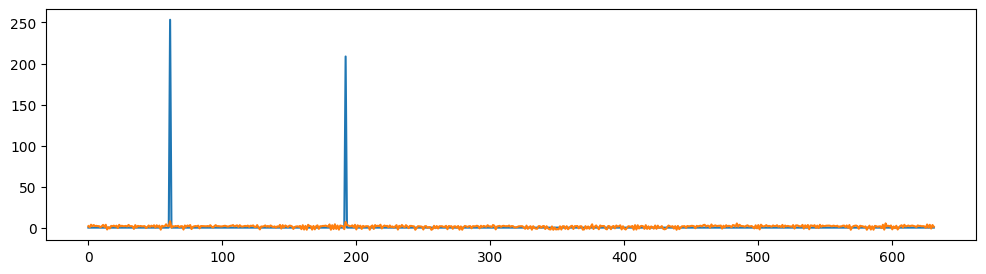

20/20 [==============================] - 0s 2ms/step


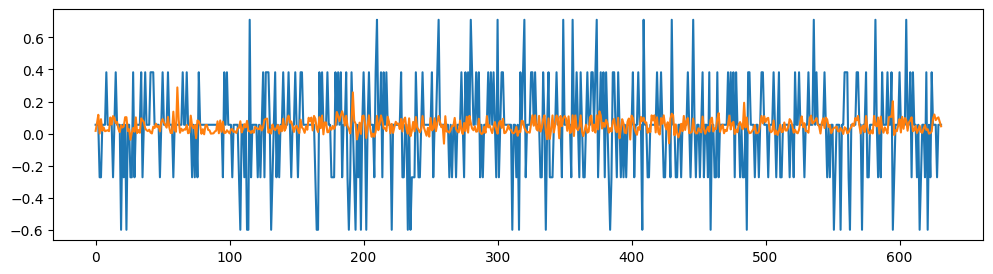

20/20 [==============================] - 0s 2ms/step


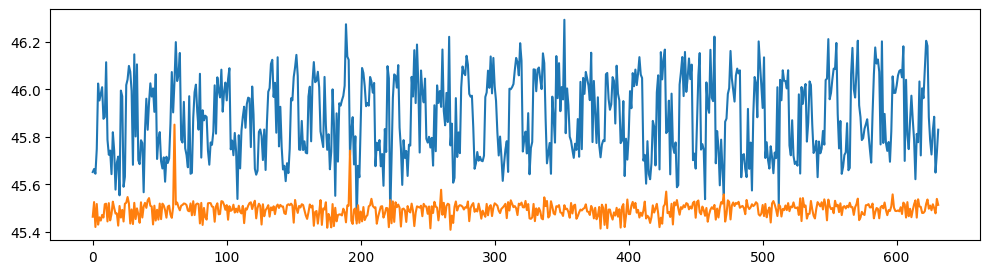

20/20 [==============================] - 0s 2ms/step


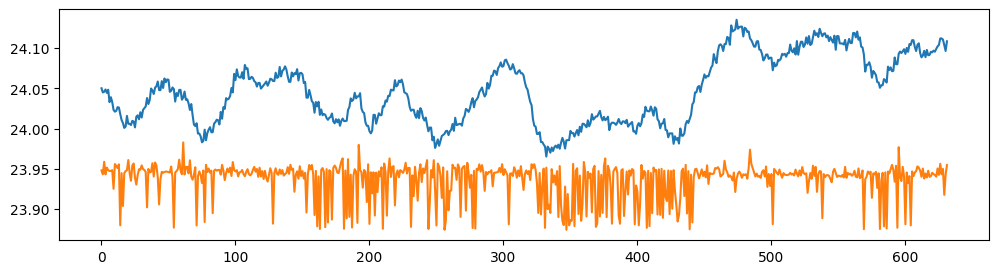

20/20 [==============================] - 0s 2ms/step


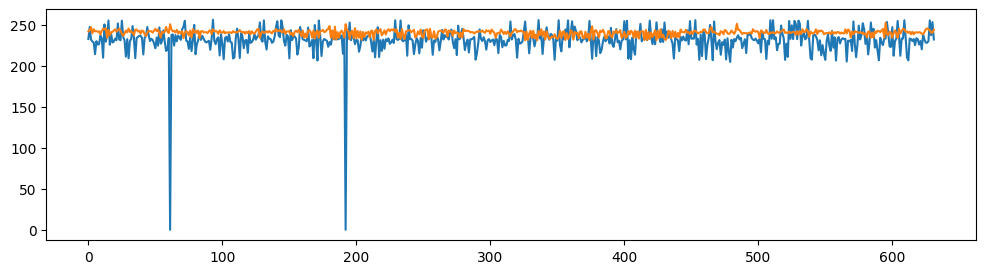

20/20 [==============================] - 0s 2ms/step


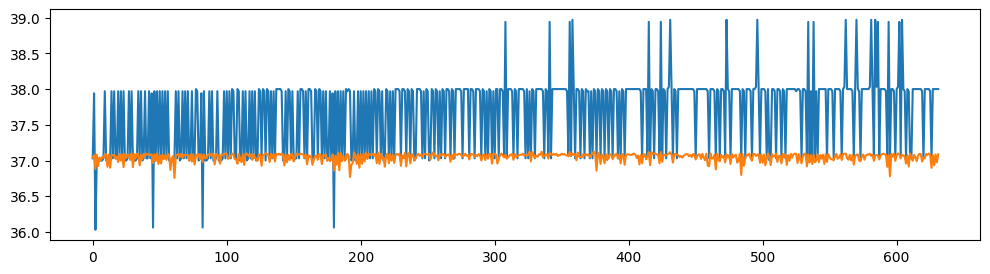

In [ ]:
for i in range(val_sc.shape[1]):
    plt.figure(figsize=(12,3))
    plt.plot(StSc.inverse_transform(val_sc)[:, i])
    plt.plot(StSc.inverse_transform(model.predict(val_sc))[:, i])
    plt.show()

**Mean** Absolute Error (MAE)

$\text{MAE} = \frac{1}{N} \sum^{N}_{i=1}|x_i - \hat{x}_i|$,

where $N$ - Total amount of data instances,  
$x_i$ - true value at a time moment $i$,  
$\hat{x}_i$ - predicted value at a time moment $i$.

In [ ]:
mean_absolute_error(val_sc, model.predict(val_sc))

20/20 [==============================] - 0s 2ms/step


0.8531251567797854

### Hyperparameters to optimize

In [ ]:
# Selecting the parameners' grid for checking
n1=[6, 5]
n2=[4, 3]
n3=[2, 1]
lr=[0.05, 0.01]
batch_size=[32, 64]

parameters = product(n1, n2, n3, lr, batch_size)
parameters_list = list(parameters)
print(f'Total number of parameter combinations: {len(parameters_list)}')

Total number of parameter combinations: 32


In [ ]:
# Table with the parameters' grid
pd.DataFrame(parameters_list, columns=['neurons 1st layer',
                                      'neurons 2nd layer',
                                      'neurons 3rd layer',
                                      'learning rate',
                                      'batch size']).head()

,neurons 1st layer,neurons 2nd layer,neurons 3rd layer,learning rate,batch size
0,6,4,2,0.05,32
1,6,4,2,0.05,64
2,6,4,2,0.01,32
3,6,4,2,0.01,64
4,6,4,1,0.05,32


### Results of the model selection

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
# Greedy brute force
errors = []
for params in tqdm(parameters_list):

    model = arch(params, train_sc)
    train_pred = model.predict(train_sc, batch_size=params[4])
    val_pred = model.predict(val_sc, batch_size=params[4])

    train_error = mean_absolute_error(train_sc, train_pred)
    val_error = mean_absolute_error(val_sc, val_pred)

    errors.append(list(params)+[train_error, val_error])

# Sort the parameters by the error value
df_errors = pd.DataFrame(errors,
                         columns=['neurons 1st layer',
                                  'neurons 2nd layer',
                                  'neurons 3rd layer',
                                  'learning rate',
                                  'batch size',
                                  'mae train',
                                  'mae val'])
df_errors.sort_values('mae val').head()

  0%|          | 0/32 [00:00<?, ?it/s]

10/10 [==============================] - 0s 2ms/step


,neurons 1st layer,neurons 2nd layer,neurons 3rd layer,learning rate,batch size,mae train,mae val
2,6,4,2,0.01,32,0.409496,0.500335
10,6,3,2,0.01,32,0.429075,0.521747
18,5,4,2,0.01,32,0.471923,0.556564
19,5,4,2,0.01,64,0.506050,0.564369
14,6,3,1,0.01,32,0.495005,0.584816


### Fitting the best model

In [ ]:
best_params = parameters_list[df_errors.sort_values('mae val').index[0]]

model = arch(best_params, train_sc)
model.summary()

Model: "model_101"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_102 (InputLayer)      [(None, 8)]               0         
                                                                 
 dense_606 (Dense)           (None, 6)                 54        
                                                                 
 batch_normalization_404 (B  (None, 6)                 24        
 atchNormalization)                                              
                                                                 
 activation_404 (Activation  (None, 6)                 0         
 )                                                               
                                                                 
 dense_607 (Dense)           (None, 4)                 28        
                                                                 
 batch_normalization_405 (B  (None, 4)                 16

20/20 [==============================] - 0s 2ms/step


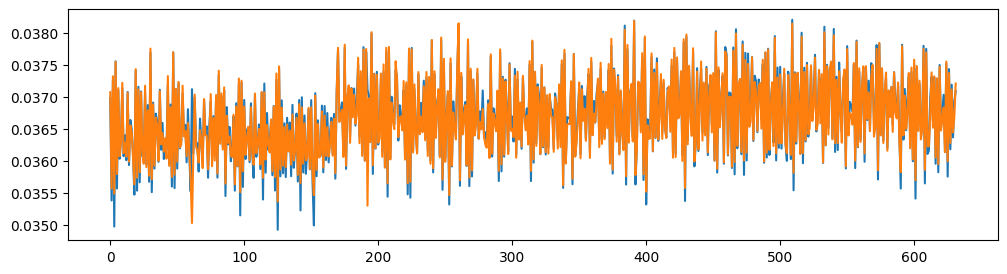

20/20 [==============================] - 0s 2ms/step


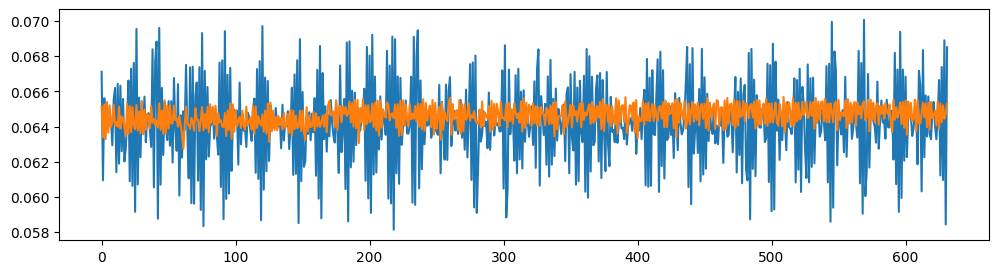

20/20 [==============================] - 0s 2ms/step


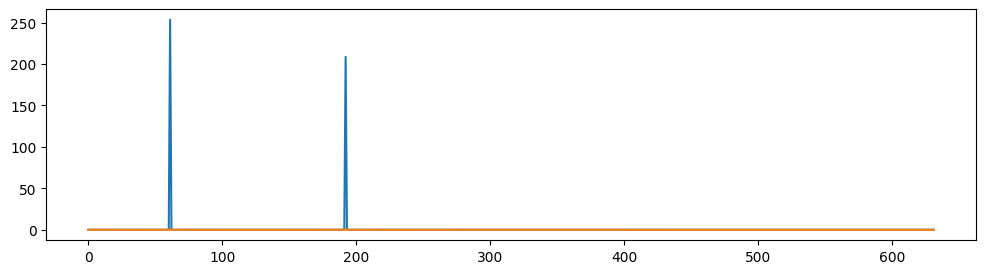

20/20 [==============================] - 0s 2ms/step


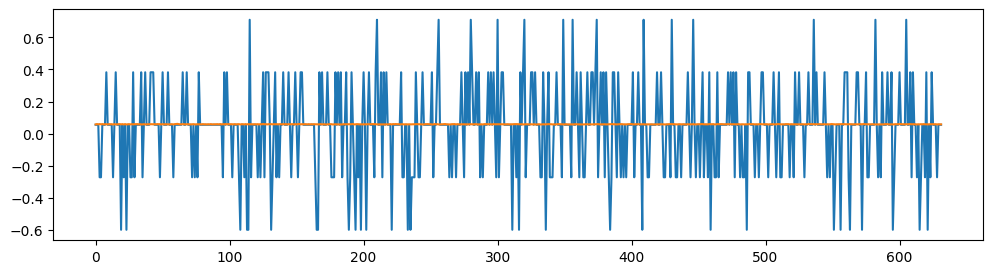

20/20 [==============================] - 0s 2ms/step


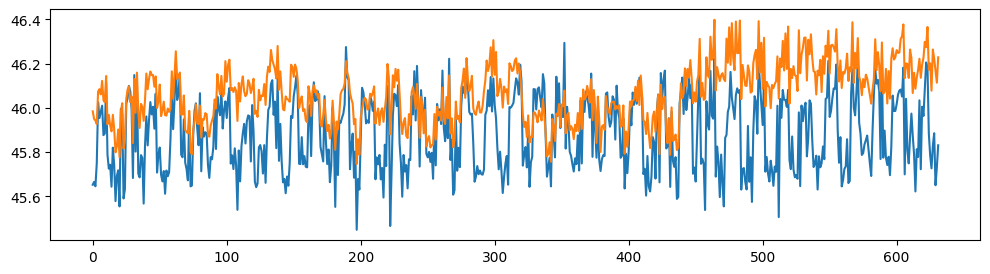

20/20 [==============================] - 0s 3ms/step


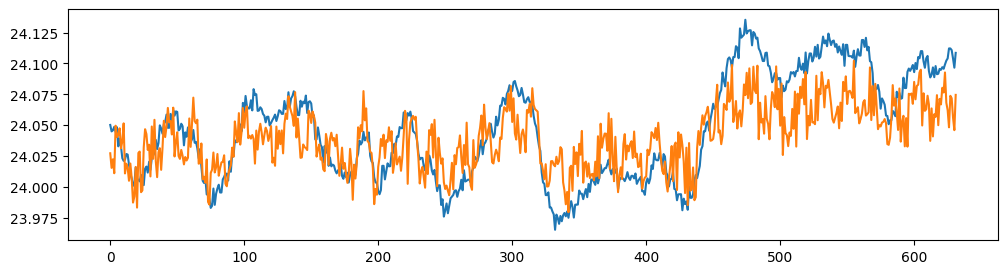

20/20 [==============================] - 0s 2ms/step


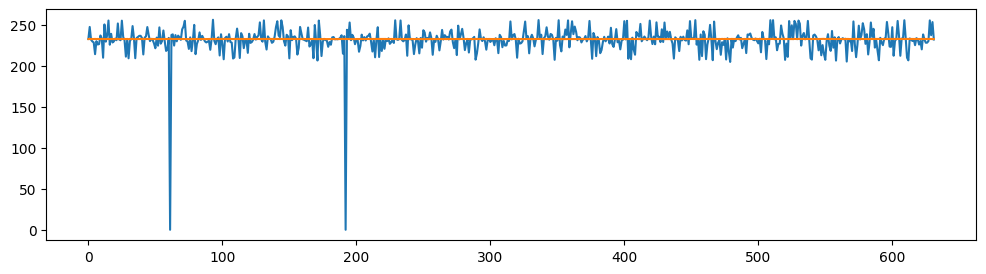

20/20 [==============================] - 0s 3ms/step


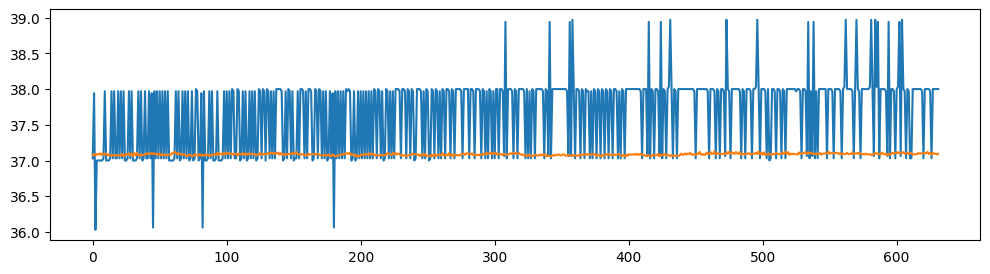

In [ ]:
for i in range(val_sc.shape[1]):
    plt.figure(figsize=(12,3))
    plt.plot(StSc.inverse_transform(val_sc)[:, i])
    plt.plot(StSc.inverse_transform(model.predict(val_sc))[:, i])
    plt.show()

*italicized text*### Health indicator

152/152 [==============================] - 0s 2ms/step


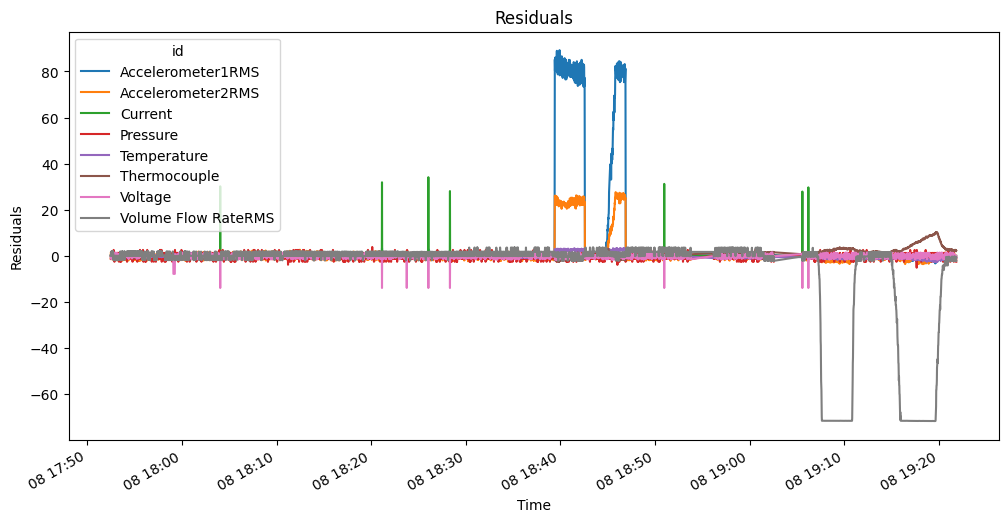

In [ ]:
test_residuals = data_sc - model.predict(data_sc)

pd.DataFrame(test_residuals, columns=data.columns, index = data.index).plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals')
plt.show()

In [ ]:
train_residuals = train_sc - model.predict(train_sc)
val_residuals = val_sc - model.predict(val_sc)

UCL = pd.DataFrame(val_residuals).abs().sum(axis=1).quantile(0.99)

20/20 [==============================] - 0s 2ms/step


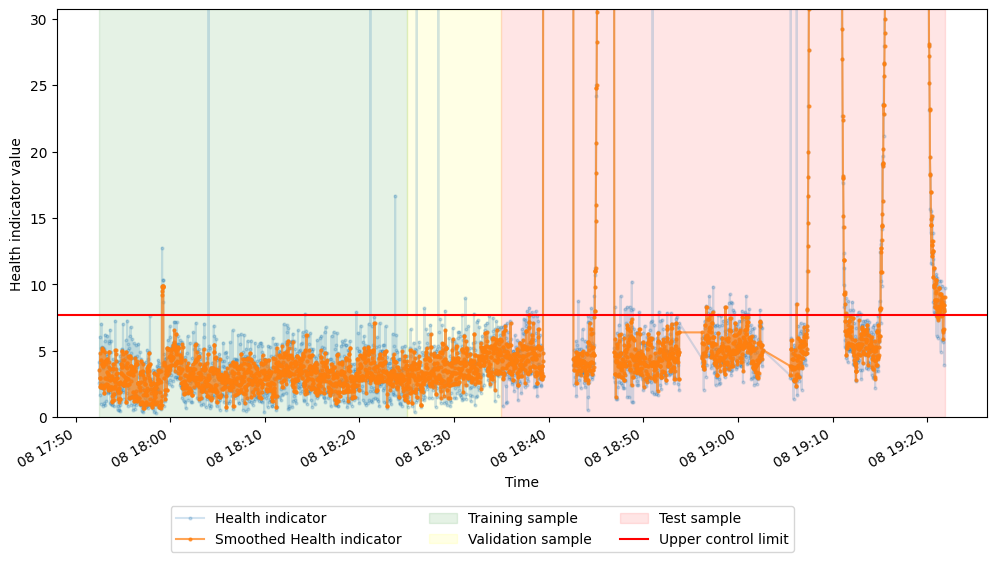

In [ ]:
# Health indicator
pd.DataFrame(test_residuals, index=data.index).abs().sum(axis=1).plot(marker='o',
                                                                      markersize=2,
                                                                      alpha=0.2,
                                                                      figsize=(12,6),
                                                                      label='Health indicator')
# Health indicator with the median filter
pd.DataFrame(test_residuals, index=data.index).abs().sum(axis=1).rolling(3).median().plot(marker='o',
                                                                                          markersize=2,
                                                                                          alpha=0.7,
                                                                                          figsize=(12,6),
                                                                                          label='Smoothed Health indicator')

plt.axvspan(data.index[0],
            '2019-07-08 18:25',
            color='green',
            alpha=0.1,
            label='Training sample')
plt.axvspan('2019-07-08 18:25',
            '2019-07-08 18:35',
            color='yellow',
            alpha=0.1,
            label='Validation sample')
plt.axvspan('2019-07-08 18:35',
            data.index[-1],
            color='red',
            alpha=0.1,
            label='Test sample')

plt.axhline(UCL, color='r', label='Upper control limit')
plt.ylim([0, 4*UCL])
plt.xlabel('Time')
plt.ylabel('Health indicator value')
plt.legend(bbox_to_anchor =(0.8, -0.2), ncol = 3)
plt.show()

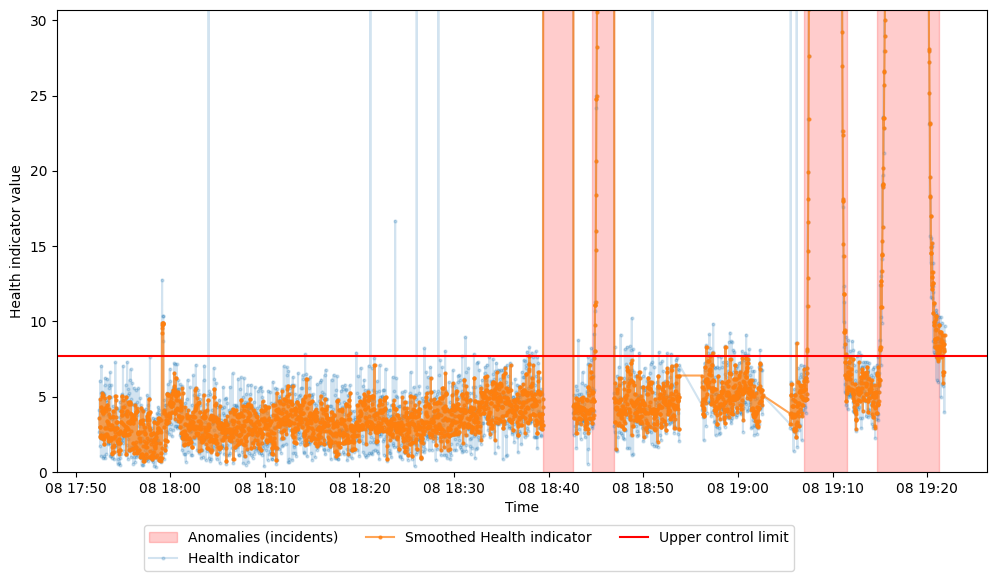

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.axvspan(
    data.index[data.index=='2019-07-08 18:39:22'][0],
    data.index[data.index=='2019-07-08 18:42:32'][0],
    alpha=0.2,
    color='red')
ax.axvspan(
    data.index[data.index=='2019-07-08 18:44:36'][0],
    data.index[data.index=='2019-07-08 18:46:51'][0],
    alpha=0.2,
    color='red')
ax.axvspan(
    data.index[data.index=='2019-07-08 19:06:57'][0],
    data.index[data.index=='2019-07-08 19:11:31'][0],
    alpha=0.2,
    color='red')
ax.axvspan(
    data.index[data.index=='2019-07-08 19:14:40'][0],
    data.index[data.index=='2019-07-08 19:21:16'][0],
    alpha=0.2,
    color='red', label='Anomalies (incidents)')
ax.plot(data.index, pd.DataFrame(test_residuals).abs().sum(axis=1),
        marker='o', markersize=2, alpha=0.2, label='Health indicator')
ax.plot(data.index, pd.DataFrame(test_residuals).abs().sum(axis=1).rolling(3).median(),
        marker='o', markersize=2, alpha=0.7, label='Smoothed Health indicator')

ax.axhline(UCL, color='r', label='Upper control limit')
ax.set_ylim([0, 4*UCL])
ax.set_xlabel('Time')
ax.set_ylabel('Health indicator value')
plt.legend(bbox_to_anchor =(0.8, -0.1), ncol = 3)
plt.show()

Here you can implement and calculate Average Detection Delay (ADD)

$\text{ADD} = \frac{1}{|Y|}\sum_{y \in Y} ( \tau_y - \theta_y )$,

where $|Y|$ - total amount of changepoints,  
$\tau_y$ - moment of detection,  
$\theta_y$ - moment of changepoint (anomaly appearing).

### Feature importance calculation

In [ ]:
def feature_importance(residuals, analysis_type="collective", date_from=None, date_till=None, weigh=True):
    """Feature importance calculation

    Parameters
    ----------
    residuals : pandas.DataFrame()

    analysis_type : str, "single"/"collective", "single" by default

    date_from : str in format 'yyyy-mm-dd HH:MM:SS', None by default

    date_till : str in format 'yyyy-mm-dd HH:MM:SS', None by default

    weigh : boolean, True by default
        If analysis_type == "collective".

    Returns
    -------
    data : pandas.DataFrame().
    """
    if date_from is None:
        start = 0
    if date_till is None:
        end = -1
    data = residuals[date_from:date_till].abs().copy()

    if (analysis_type == "collective") & (weigh == False):
        data = data.div(data.sum(axis=1), axis=0) * 100
        return pd.DataFrame(data.mean(), columns=['Feature importance, %']).T
    elif (analysis_type == "collective") & (weigh == True):
        data = data.mean().div(data.mean().sum(), axis=0) * 100
        return pd.DataFrame(data, columns=['Feature importance, %']).T
    elif analysis_type == "single":
        return data.div(data.sum(axis=1), axis=0) * 100

In [ ]:
for dates in [['2019-07-08 18:39:22','2019-07-08 18:42:32'],
              ['2019-07-08 18:44:36','2019-07-08 18:46:51'],
              ['2019-07-08 19:06:57','2019-07-08 19:11:31'],
              ['2019-07-08 19:14:40','2019-07-08 19:21:16']]:
    print(f'Incident since {dates[0]} till {dates[1]}')
    display(feature_importance(pd.DataFrame(test_residuals, index=data.index, columns=data.columns), date_from=dates[0], date_till=dates[1]))
    print('\n')

Incident since 2019-07-08 18:39:22 till 2019-07-08 18:42:32


id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
"Feature importance, %",73.424105,21.186079,0.005816,0.656591,2.311436,1.289889,0.492079,0.634005




Incident since 2019-07-08 18:44:36 till 2019-07-08 18:46:51


id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
"Feature importance, %",70.340943,22.212328,0.006621,0.901748,2.956572,1.647034,0.629579,1.305175




Incident since 2019-07-08 19:06:57 till 2019-07-08 19:11:31


id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
"Feature importance, %",1.61486,2.207829,0.013388,1.016782,1.580028,4.110714,0.81225,88.644148




Incident since 2019-07-08 19:14:40 till 2019-07-08 19:21:16


id,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS
"Feature importance, %",2.475849,2.347886,0.017265,1.144199,2.336567,8.523139,0.827657,82.327439


In [ ]:
Zmodel.save('content/new_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Load the dataset
data = pd.read_csv('/content/book12.csv')

# Preprocessing (assuming the dataset structure is similar to the previous one)
# Pivot the table
data_pivot = data.pivot_table(values='value', index='datetime', columns='id')

# Data scaling (using the same scaler used during model training)
scaler = StandardScaler()
scaler.fit(train_sc)  # Assuming train_data is the scaled training dataset
data_scaled = scaler.transform(data_pivot)

# Load the trained model
model = load_model('content/new_model.h5')

# Predict the reconstructed values
reconstructed_data = model.predict(data_scaled)

# Calculate residuals
residuals = data_scaled - reconstructed_data

# Calculate health indicator
health_indicator = np.abs(residuals).sum(axis=1)

# Calculate the absolute sum of residuals
abs_sum_residuals = np.abs(val_residuals).sum(axis=1)

# Calculate the upper control limit (UCL) based on the 99th percentile
UCL = np.quantile(abs_sum_residuals, 0.99)


# Calculate the upper control limit (UCL)
#UCL = val_residuals.abs().sum(axis=1).quantile(0.99)  # Assuming val_residuals is available

# Check for anomalies
anomalies = health_indicator > UCL

# Print the results
print("Anomalies:")
print(anomalies)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


2/2 [==============================] - 1s 7ms/step
Anomalies:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
